In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed, connectivity_profile

warnings.filterwarnings('ignore')

In [2]:
# Download and cache the sqlite file
db = SynphysDatabase.load_current('small')

# Load all cell pairs associated with mouse V1 projects
mouse_pairs = db.pair_query(project_name=["mouse V1 coarse matrix", "mouse V1 pre-production"]).all()

print("loaded %d cell pairs" % len(mouse_pairs))

loaded 83552 cell pairs


In [3]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'),  'cortical_layer': '4'},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b')},
}

In [4]:
cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [5]:
# pick cell class we want to analysis

pre_class = cell_classes['l23sst']
post_class = cell_classes['l23vip']
sigma = 100e-6 # sigma E2E 127, E2I 99, I2E 96 I2I 126 from Allen Paper doesn't matter much though
# rho = Cell density 
# density of pre_class cells (presynaptic cells)
# For SST cells in mouse V1, density is ~10^4 cells/mm² lets say 
rho = 1e4 * 1e6  # cells per m² (10^4 cells/mm² * 10^6 mm²/m²)

In [6]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=mouse_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(mouse_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups, sigma=sigma, dist_measure='lateral_distance')

## Explanation of Connection Probability Metrics

- **Connection Probability**: The raw fraction of probed cell pairs that showed a synaptic connection, calculated as $n_{\text{connected}} / n_{\text{probed}}$. This is biased by the distances at which pairs were tested, as closer pairs are more likely to connect.
- **Distance-Adjusted Connection Probability**: An estimate of the maximum connection probability at zero intersomatic distance, assuming connectivity decays as a Gaussian with distance. The model is $p(d) = p_{\max} \exp\left( -\frac{d^2}{2\sigma^2} \right)$. The adjustment scales the raw probability by the inverse of the average expected probability across probed distances: $p_{\text{adjusted}} = \frac{n_{\text{connected}} / n_{\text{probed}}}{\langle \exp\left( -\frac{d_{\text{probed}}^2}{2\sigma^2} \right) \rangle}$. 


In [7]:
print("Connectivity results for %s => %s" % (pre_class, post_class))
print("  %d synapses found out of %d probed" % (
    results[pre_class, post_class]['n_connected'],
    results[pre_class, post_class]['n_probed'],
))
print("  %0.2f%% connection probability" % (
    results[pre_class, post_class]['connection_probability'][0] * 100,
))
print("     95%% confidence interval: %0.2f%%-%0.2f%%" % (
    results[pre_class, post_class]['connection_probability'][1] * 100,
    results[pre_class, post_class]['connection_probability'][2] * 100,
))
print("  %0.2f%% distance-adjusted connection probability" % (
    results[pre_class, post_class]['adjusted_connectivity'][0] * 100,
))
print("     95%% confidence interval: %0.2f%%-%0.2f%%" % (
    results[pre_class, post_class]['adjusted_connectivity'][1] * 100,
    results[pre_class, post_class]['adjusted_connectivity'][2] * 100,
))
    

Connectivity results for l23sst => l23vip
  25 synapses found out of 88 probed
  28.41% connection probability
     95% confidence interval: 19.30%-39.02%
  37.18% distance-adjusted connection probability
     95% confidence interval: 25.26%-51.07%


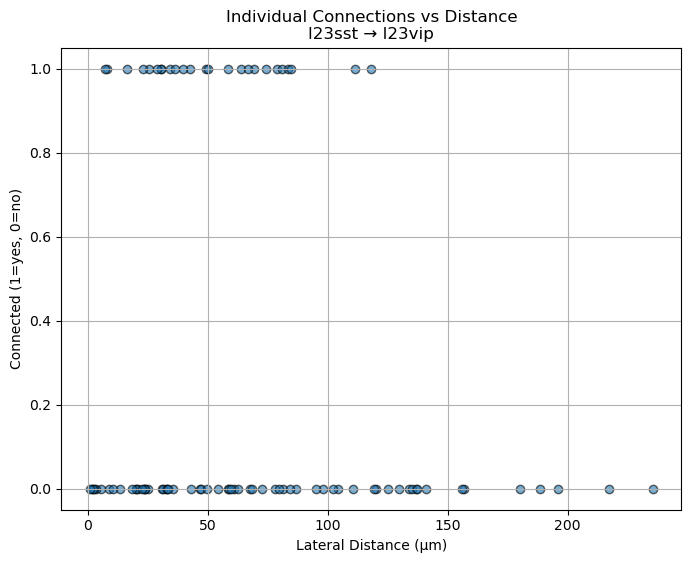

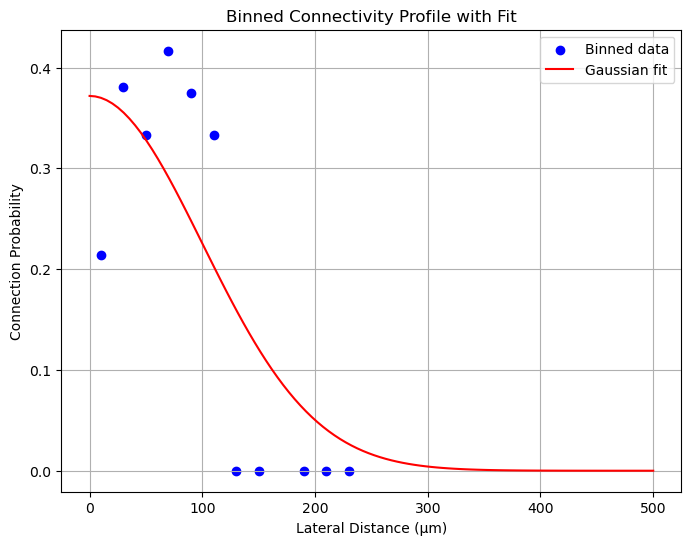

In [8]:
distances = results[pre_class, post_class]['probed_distances']
connections = results[pre_class, post_class]['connected_distances']

# Compute binned connectivity profile
bin_edges = np.arange(0, 500e-6, 20e-6)
xvals, prop, lower, upper = connectivity_profile(connections.astype(float), distances, bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit parameters
pmax = results[pre_class, post_class]['adjusted_connectivity'][0]
d_fit = np.linspace(0, 500e-6, 100)
p_fit = pmax * np.exp(-d_fit**2 / (2 * sigma**2))

# First figure: Scatter plot of individual connections
plt.figure(figsize=(8, 6))
plt.scatter(distances * 1e6, connections, alpha=0.6, edgecolors='k')
plt.xlabel('Lateral Distance (μm)')
plt.ylabel('Connected (1=yes, 0=no)')
plt.title(f'Individual Connections vs Distance\n{pre_class} → {post_class}')
plt.grid(True)
plt.show()

# Second figure: Binned profile with Gaussian fit
plt.figure(figsize=(8, 6))
plt.scatter(bin_centers * 1e6, prop, color='blue', label='Binned data')
plt.plot(d_fit * 1e6, p_fit, 'r-', label='Gaussian fit')
plt.xlabel('Lateral Distance (μm)')
plt.ylabel('Connection Probability')
plt.title('Binned Connectivity Profile with Fit')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Assuming uniform cell distribution, let's solve for convergence onto a cell using Gaussian distance rule

# pmax from adjusted connectivity
pmax = results[pre_class, post_class]['adjusted_connectivity'][0]

# Expected convergence C = pmax * rho * 2 * pi * sigma²
# This is a 2D calculation since cortical connections use lateral distance
convergence = pmax * rho * 2 * np.pi * sigma**2

print(f"Estimated convergence from {pre_class} to {post_class}: {convergence:.2f} connections per postsynaptic cell")
print(f"Based on pmax = {pmax:.4f}, rho = {rho:.2e} cells/m², sigma = {sigma*1e6:.0f} μm")

Estimated convergence from l23sst to l23vip: 233.62 connections per postsynaptic cell
Based on pmax = 0.3718, rho = 1.00e+10 cells/m², sigma = 100 μm
